Using the images marked as valid per cluster, we pass them through the CNN and extract their feature vectors. the results are stored at a per-country basis. For example, all Malawi feature extractions will go into results/malawi_2016/cnn.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

import matplotlib.pyplot as plt

%matplotlib inline

/Users/omshah/opt/anaconda3/envs/pypoverty38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [2]:
BASE_DIR = '..'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
CNN_TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, 'data', 'cnn_images')
CNN_DIR = os.path.join(BASE_DIR, 'models', 'trained_model.pt')

In [3]:
os.makedirs(RESULTS_DIR, exist_ok=True)
for country in ['ethiopia_2015']:
    os.makedirs(os.path.join(RESULTS_DIR, country), exist_ok=True)

# Feature extract with CNN
If you have run this step before, you can skip it and run the commented out code in the next section to quick-start.

In [5]:
df_images = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_actual.csv'))

In [6]:
df_images

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,temp,country,temp_bin,is_train
0,3.410784802784024_39.47107816189403_3.45570056...,3.410785,39.471078,3.455701,39.515994,14.854634,2.010416,eth,0,True
1,3.4257567241860163_39.47107816189403_3.4557005...,3.425757,39.471078,3.455701,39.515994,14.854634,2.010416,eth,0,False
2,3.440728645588008_39.47107816189403_3.45570056...,3.440729,39.471078,3.455701,39.515994,14.854634,2.010416,eth,0,True
3,3.45570056699_39.47107816189403_3.45570056699_...,3.455701,39.471078,3.455701,39.515994,14.854634,2.010416,eth,0,True
4,3.470672488391992_39.47107816189403_3.45570056...,3.470672,39.471078,3.455701,39.515994,14.854634,2.010416,eth,0,True
...,...,...,...,...,...,...,...,...,...,...
24907,13.969398585198007_39.548101340101994_13.98437...,13.969399,39.548101,13.984371,39.533129,7.824775,1.799999,eth,0,False
24908,13.9843705066_39.548101340101994_13.9843705066...,13.984371,39.548101,13.984371,39.533129,7.824775,1.799999,eth,0,True
24909,13.999342428001992_39.548101340101994_13.98437...,13.999342,39.548101,13.984371,39.533129,7.824775,1.799999,eth,0,False
24910,14.014314349403984_39.548101340101994_13.98437...,14.014314,39.548101,13.984371,39.533129,7.824775,1.799999,eth,0,True


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} as backend')
model = torch.load(CNN_DIR, map_location=device)

Using cpu as backend


In [8]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

In [9]:
# rip off the final layers
model.classifier = model.classifier[:4]

In [10]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

In [11]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# custom dataset for fast image loading and processing
# does not follow the usual style of folder -> folder for each class -> image
# we just want one folder with images
class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]

        # Load image
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)
        
        # dataloaders need to return a label, but for the forward pass we don't really care
        return X, -1
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:,:,:3]
        im = self.transformer(im)
        return im

model.eval()  
classes = [0, 1, 2]
# shape of final array will be (num_validation_images, 4096)
# we also want to record the image each index represents
feats = np.zeros(((~df_images['is_train']).sum(), 4096))
image_order = []
i = 0
for c in classes:
    # use the validation images to do the forward pass
    dataset = ForwardPassDataset(os.path.join(CNN_TRAIN_IMAGE_DIR, 'valid', str(c)), transformer)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)
    image_order += dataset.image_list
    # forward pass for this class
    for inputs, _ in tqdm(dataloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        feats[i:i+len(inputs),:] = outputs.cpu().detach().numpy()
        i += len(inputs)

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

In [12]:
feats

array([[-2.11736917, -0.14869089, -0.45589617, ..., -0.23898168,
        -0.04147298, -1.42753351],
       [-3.26886773,  0.05036484,  1.19110227, ...,  0.60914648,
         0.92665344, -2.77215409],
       [-0.73454875,  0.75598794,  0.02162023, ...,  1.51512825,
         0.04801628, -1.04182744],
       ...,
       [-0.14195265,  0.92747992, -0.97453463, ...,  0.04313407,
        -0.52442467, -0.55650008],
       [ 0.7211749 , -0.50010276,  0.00896755, ...,  0.73156923,
        -0.51442081, -0.92654896],
       [-1.03279114, -0.96635014, -0.22030711, ..., -0.67239964,
        -2.16085267, -0.85750371]])

In [13]:
forward_pass_df = pd.DataFrame.from_dict({'image_name': image_order, 'feat_index': np.arange(len(image_order))})
forward_pass_df.head()

,image_name,feat_index
0,13.175867187596015_37.75771137869602_13.205811...,0
1,13.533819891501992_39.493748301501995_13.51884...,1
2,9.749401925181992_34.758499371703984_9.7344300...,2
3,11.872140456903985_39.6046072003_11.8421966141...,3
4,4.093109885245976_41.96087191160398_4.04819412...,4


In [14]:
df_consumption = pd.merge(left=df_images, right=forward_pass_df, on='image_name')

In [15]:
# have we maintained all validation images?
assert len(df_consumption) == (~df_images['is_train']).sum()

In [16]:
df_consumption.tail()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,temp,country,temp_bin,is_train,feat_index
4979,14.014314349403984_39.5331294187_13.9843705066...,14.014314,39.533129,13.984371,39.533129,7.824775,1.799999,eth,0,False,346
4980,13.939454742394023_39.548101340101994_13.98437...,13.939455,39.548101,13.984371,39.533129,7.824775,1.799999,eth,0,False,185
4981,13.969398585198007_39.548101340101994_13.98437...,13.969399,39.548101,13.984371,39.533129,7.824775,1.799999,eth,0,False,377
4982,13.999342428001992_39.548101340101994_13.98437...,13.999342,39.548101,13.984371,39.533129,7.824775,1.799999,eth,0,False,318
4983,14.029286270805976_39.548101340101994_13.98437...,14.029286,39.548101,13.984371,39.533129,7.824775,1.799999,eth,0,False,859


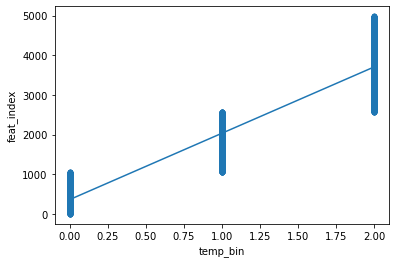

In [17]:
df_consumption.plot.scatter(x="temp_bin", y="feat_index")
x = df_consumption['temp_bin']
y = df_consumption['feat_index']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

## Aggregate Features
For each country, we aggregate the image features per cluster and save them to results/country/cnn

In [18]:
country_abbrv = ['eth']
country_dir = ['ethiopia_2015']

for ca, cd in zip(country_abbrv, country_dir):
    df_c = df_consumption[df_consumption['country'] == ca]
    group = df_c.groupby(['cluster_lat', 'cluster_lon'])
    x = np.zeros((len(group), 4096))
    cluster_list = [] # the corresponding clusters (lat, lon) to the x aggregate feature array
    for i, g in enumerate(group):
        lat, lon = g[0]
        im_sub = df_consumption[(df_consumption['cluster_lat'] == lat) & (df_consumption['cluster_lon'] == lon)].reset_index(drop=True)
        agg_feats = np.zeros((len(im_sub), 4096))
        for j, d in im_sub.iterrows():
            agg_feats[j,:] = feats[d.feat_index]
        agg_feats = agg_feats.mean(axis=0) # averages the features across all images in the cluster

        x[i,:] = agg_feats
        cluster_list.append([lat, lon])
    # save to the correct directory
    save_dir = os.path.join(RESULTS_DIR, cd, 'cnn')
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'cluster_feats.npy'), x)
    pickle.dump(cluster_list, open(os.path.join(save_dir, 'cluster_order.pkl'), 'wb')) 
    